In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn

from torch.autograd import Variable
from random import shuffle
from scipy.stats import gamma, norm


import sys
sys.path.append('../../')
from model_comparison.utils import *
from model_comparison.mdns import *


%matplotlib inline

## Generate Gaussian data

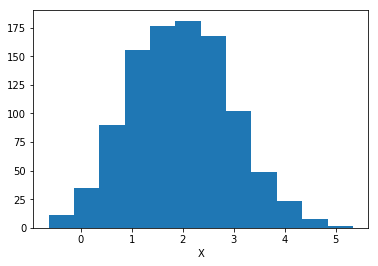

In [94]:
# set parameters for prior 
prior_mu = 2. 
prior_sigma = 4. 

# set true mean
true_mu = 2.

N = 1000
X_o = np.random.normal(loc=true_mu, size=N)

X_var = Variable(torch.Tensor(X_o.astype(float)))

plt.hist(X_o, bins=12);
plt.xlabel('X');

In [3]:
# we need to define a generative model to generate samples (theta, x)
def generate_dataset(N, m):
    # N data sets 
    # each with m samples 
    
    X = []
    thetas = []
    
    for i in range(N): 
        # sample from the prior 
        theta = np.random.normal(prior_mu, prior_sigma)

        # generate samples
        x = np.random.normal(theta, size=m)
        
        # as data we append the summary stats
        X.append(calculate_stats(x).astype(float)) 
        thetas.append([theta])
    
    return np.array(X), np.array(thetas)

# calculate summary stats, for poisson this is just x, so for a vector it is sum x
def calculate_stats(x): 
    sx = np.array([np.sum(x).astype(float)])
#    sx = x
    return sx

def batch_generator(dataset, batch_size=5):
    shuffle(dataset)
    N_full_batches = len(dataset) // batch_size
    for i in range(N_full_batches):
        idx_from = batch_size * i
        idx_to = batch_size * (i + 1)
        xs, ys = zip(*[(x, y) for x, y in dataset[idx_from:idx_to]])
        yield xs, ys

In [131]:
X, Y = generate_dataset(10000, N)

In [132]:
xz, data_norm = normalize(X)
yz, prior_norm = normalize(Y)

In [133]:
# define a network to approximate the posterior with a MoG 
mdn = UnivariateMogMDN(ndim_input=1, n_components=1)
optimizer = torch.optim.Adam(mdn.parameters(), lr=0.01)
trainer = Trainer(mdn, optimizer, verbose=True)

In [134]:
loss = trainer.train(xz, yz.squeeze(), n_epochs=400, n_minibatch=50)

training: 100%|██████████| 400/400 [01:54<00:00,  5.51it/s]


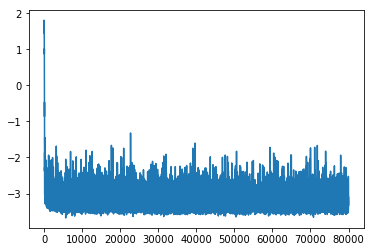

In [135]:
plt.plot(loss)

In [136]:
# now evaluate the model at the observed data 
stats_o = calculate_stats(X_o).reshape(1, 1)
sxozt, _ = normalize(stats_o, data_norm)
thzt, _ = normalize(true_mu, prior_norm)

X_var = Variable(torch.Tensor(stats_o))

(out_alpha, out_sigma, out_mu) = mdn(X_var)

In [163]:
thetas = np.linspace(-2, 2, 1000)

post = mdn.predict(sxozt)
post_vals = post.eval_numpy(thetas)
prior = norm.pdf(thetas, loc=prior_mu, scale=prior_sigma)

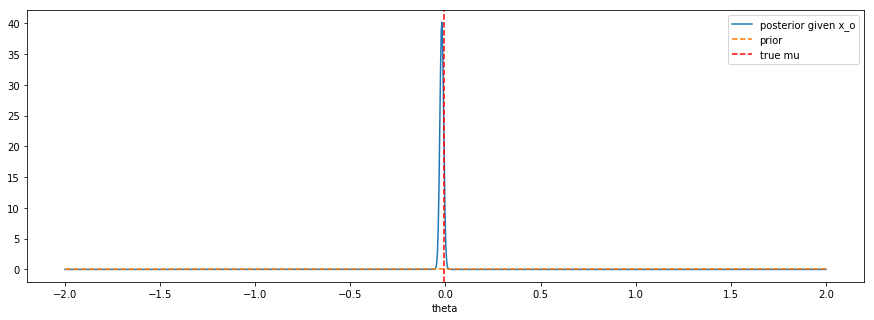

In [164]:
plt.figure(figsize=(15, 5))
plt.plot(thetas, post_vals, label='posterior given x_o')
plt.plot(thetas, prior, '--', label='prior')
plt.axvline(x=thzt, label='true mu', linestyle='--', color='r')
plt.xlabel('theta')
plt.legend();

## Posterior software validation 

Calculate credible intervals and quantiles

In [185]:
# generate testing data 
ntest = 500
X, Y = generate_dataset(ntest, N)
xz, _ = normalize(X, data_norm)
yz, _ = normalize(Y, prior_norm)

In [186]:
# run loop over test data: predict posterior, calculate quantiles, check credible intervals
qis = np.zeros(ntest)
credible_intervals = np.arange(.1, 1., .1)
ci_counts = np.zeros((credible_intervals.shape[0], ntest))
for ii, (xi, thi) in enumerate(zip(xz, yz)): 
    # get posterior 
    post = mdn.predict(xi.reshape(1, -1))
    
    # get quantile 
    qis[ii] = post.get_quantile(thi)
    
    # get ci counts 
    ci_counts[:, ii] = post.get_credible_interval_counts(thi, credible_intervals)

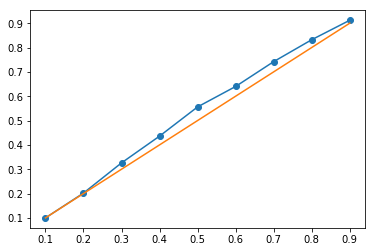

In [189]:
plt.plot(credible_intervals, ci_counts.mean(axis=1), 'o-')
plt.plot(credible_intervals, credible_intervals)

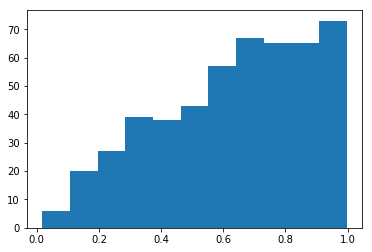

In [188]:
plt.hist(qis, bins='auto');